In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Boosting algorithms (cca 5min running on CPU)

- AdaBoost
- Gradient tree boosting
- eXtreme Gradient Boosting (XGBoost)
- their comparative analysis

# AdaBoost
AdaBoost short for Adaptive Boosting is an ensemble learning used in machine learning for classification and regression problems. The main idea behind AdaBoost is to iteratively train the weak classifier on the training dataset with each successive classifier giving more weightage to the data points that are misclassified. The final AdaBoost model is decided by combining all the weak classifier that has been used for training with the weightage given to the models according to their accuracies. The weak model which has the highest accuracy is given the highest weightage while the model which has the lowest accuracy is given a lower weightage.

Here are the steps followed by the AdaBoost algorithm:
- **Step 1: Initialize Weights -** Initially, each instance in the training dataset is assigned an equal weight of `1/N`, where `N` is the total number of instances.
- **Step 2: Loop Over Classifiers -** AdaBoost selects a weak classifier in each iteration and adjusts its weights after each classification.
- **Step 3: Train Weak Classifier -** A weak classifier is trained on the training data. The training process takes into account the weights of the instances.
- **Step 4: Calculate Error -** The error rate (`err`) of the classifier is calculated as the weighted sum of the incorrectly classified instances. The error influences how much say the classifier will have in the final decision.
- **Step 5: Compute Classifier Weight -** The classifier is assigned a weight (`alpha`) based on its accuracy. More accurate classifiers are given more weight by this formula:`alpha = 0.5 * log((1 - err) / err)`
- **Step 6: Update Sample Weights -** Weights of the incorrectly classified instances are increased so that the classifier is forced to focus on the difficult cases in the next round. The weights of correctly classified instances are decreased. The update rules are as follows: For incorrectly classified instances: `new_weight = weight * exp(alpha)`. For correctly classified instances: `new_weight = weight * exp(-alpha)`.
- **Step 7:  Normalize Weights -** After updating the weights, they need to be normalized so that they sum up to 1, making them a valid probability distribution.
- **Step 8: Combine Weak Classifiers -** The weighted weak classifiers form the final model. Predictions are made by calculating the weighted majority vote of the weak classifiers.
- **Step 9: Final Model -** The sign of the weighted sum of predictions from the weak classifiers is used to make the final prediction. A positive sum results in a positive class prediction, and a negative sum results in a negative class prediction.
- **Step 10: Terminate or Continue -** The learning process can stop when a certain number of iterations is reached or a desired level of accuracy is achieved.

### Practical Example of Using AdaBoost:

In this practical session, we will explore the AdaBoost algorithm and our goals are to:
1. Understand the basics of the AdaBoost algorithm and why it's powerful.
2. Apply AdaBoost to a real-world dataset and observe its performance.
3. Compare the performance of AdaBoost with a single decision tree to illustrate the benefits of using boosting.
4. Visualize the effects of AdaBoost on decision boundaries and feature importance.

The dataset has 494020 instances and 42 features.
Base Model Accuracy: 78.49%
AdaBoost Training Time: 19.305 seconds
AdaBoost Prediction Time: 2.239 seconds
AdaBoost Model Accuracy: 98.04%
Base Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       655
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00       382
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.50      1.00      0.67     31983
          10       0.00      0.00      0.00        61
          11       0.00      0.00      0.00     29154
          12       0.00      0.00      0.00         2
          14       0

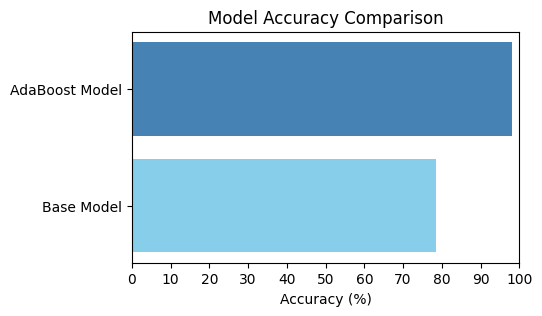

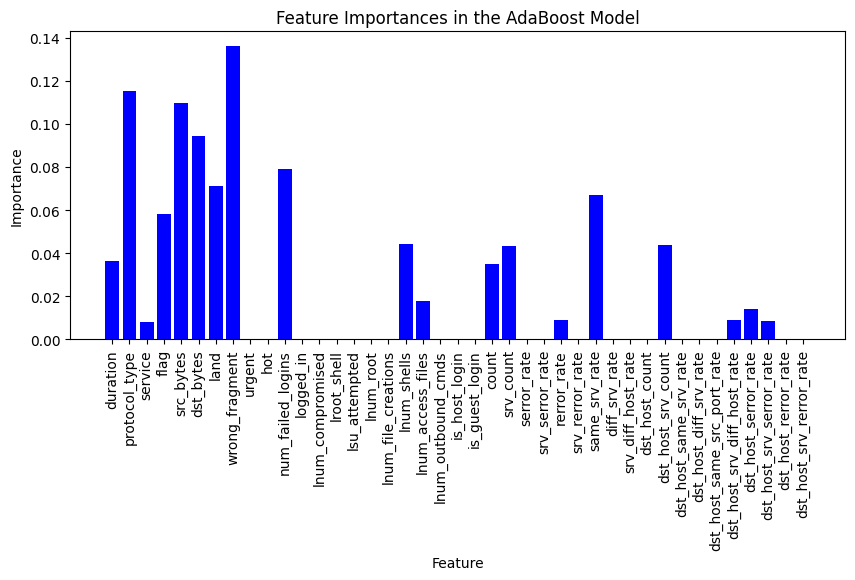


Conclusion and Interpretation:
From the comparison, we see that AdaBoost significantly improved the accuracy of the model compared to the base decision tree model.
The feature importances show which variables have the most influence on the model's decisions, useful for further tuning or understanding the predictive factors.



In [6]:
# Importing necessary libraries
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import seaborn as sns  # Additional import for enhanced visualizations
import time
import numpy as np

# Load the dataset from OpenML
data = fetch_openml(name='KDDCup99', version=1, as_frame=True, parser='auto')
df = data.frame
print(f"The dataset has {df.shape[0]} instances and {df.shape[1]} features.")

# Preprocess the dataset
# Replace missing values marked as '?' with NaN and then drop these entries
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)

# Encode categorical variables as integers because most machine learning models require numerical input
# Store label encoders in a dictionary for possible inverse transform if needed
label_encoders = {}
for column in df.select_dtypes(include=['category', 'object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Prepare the data for training/testing
X = df.drop('label', axis=1)  # Features
y = df['label'].astype(int)   # Target variable

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a DecisionTreeClassifier which will be used as the base estimator
# with a max depth of 1, this creates a "stump" that AdaBoost will build upon
base_clf = DecisionTreeClassifier(max_depth=1, random_state=42)

# Train the single Decision Tree model
base_clf.fit(X_train, y_train)

# Make predictions with the single Decision Tree
y_base_pred = base_clf.predict(X_test)

# Evaluate the single Decision Tree model
base_accuracy = accuracy_score(y_test, y_base_pred) * 100
print(f"Base Model Accuracy: {base_accuracy:.2f}%")

# Create an AdaBoost instance with the base classifier
# The AdaBoost model is created by combining 200 such "stumps" and adjusting them based on their error
ada_clf = AdaBoostClassifier(
    estimator=base_clf,
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

# Time the training of the AdaBoost model
start_time = time.time()
# Train the AdaBoost model
ada_clf.fit(X_train, y_train)
ada_train_time = time.time() - start_time
print(f"AdaBoost Training Time: {ada_train_time:.3f} seconds")

# Time the predictions
start_time = time.time()
# Make predictions with AdaBoost
y_ada_pred = ada_clf.predict(X_test)
ada_predict_time = time.time() - start_time
print(f"AdaBoost Prediction Time: {ada_predict_time:.3f} seconds")

# Evaluate the AdaBoost model
ada_accuracy = accuracy_score(y_test, y_ada_pred) * 100
print(f"AdaBoost Model Accuracy: {ada_accuracy:.2f}%")

# Generate and compare classification reports for each model
# This provides a detailed breakdown of precision, recall, f1-score for each class
base_report = classification_report(y_test, y_base_pred, zero_division=0)
ada_report = classification_report(y_test, y_ada_pred, zero_division=0)
print("Base Model Classification Report:")
print(base_report)
print("AdaBoost Model Classification Report:")
print(ada_report)

# Visualize the performance of the base vs. AdaBoost models
# A horizontal bar chart is used for clear comparison between model accuracies
plt.figure(figsize=(5, 3))
plt.barh(['Base Model', 'AdaBoost Model'], [base_accuracy, ada_accuracy], color=['skyblue', 'steelblue'])
plt.xlabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 100)  # Set the x-axis limits from 0 to 100 for percentages
plt.xticks(np.arange(0, 101, 10))  # Set the ticks to be in increments of 10%
plt.show()

# After fitting the AdaBoost model, extract the feature importances
importances = ada_clf.feature_importances_

# Plotting the feature importances provides insight into which features the model finds most important
plt.figure(figsize=(10, 4))
plt.bar(X.columns, importances, color='blue')
plt.title("Feature Importances in the AdaBoost Model")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)  # Rotate x-axis labels to improve readability
plt.show()

# Conclusion and Interpretation
print("\nConclusion and Interpretation:")
print("From the comparison, we see that AdaBoost significantly improved the accuracy of the model compared to the base decision tree model.")
print("The feature importances show which variables have the most influence on the model's decisions, useful for further tuning or understanding the predictive factors.\n")

# Gradient tree boosting

Gradient Tree Boosting is an ensemble learning technique that builds a predictive model in a stage-wise fashion. It combines the predictions from a series of weak learners, usually decision trees, to create a strong, accurate model. The algorithm focuses on minimizing a loss function by adding weak models that correct the errors made by the previous models. It's called "gradient" because it optimizes the model by following the gradient of the loss function.

Here are the steps followed by the Gradient tree boosting algorithm:
- **Step 1: Initialize the Model -** Start with a single tree, which could be the mean of the targets for regression, or the log odds for a classification problem.
- **Step 2: Loop Over Trees -** Iteratively add trees to the ensemble. Each new tree is fitted on the negative gradient of the loss function (hence the name ‘Gradient’ Boosting).
- **Step 3: Fit the Tree to Residuals -** Fit a decision tree to the negative gradient of the loss function with respect to the predictions of the current model.
- **Step 4: Calculate the Loss -** Evaluate the loss of the current model using the loss function, which is typically mean squared error for regression and log loss for classification.
- **Step 5: Compute Tree Output -** The output of each tree is scaled by a learning rate (also called the shrinkage factor) to prevent overfitting.
- **Step 6: Update the Model -** Add the scaled output of the new tree to the model.
- **Step 7: Prune the Tree -** Optionally, prune the tree to mitigate over-complexity.
- **Step 8: Combine Trees -** The final model is the sum of the output of all trees.
- **Step 9: Final Model -** The prediction of the ensemble is the sum of the predictions from all trees.
- **Step 10: Terminate or Continue -** The process can be stopped when a certain number of trees is reached, or if the improvement of the loss is below a certain threshold.

### Practical Example of Using Gradient Tree Boosting:

In this practical session, we will delve into Gradient Tree Boosting, a powerful ensemble machine learning algorithm. Our objectives are to:
1. Comprehend the fundamentals of Gradient Tree Boosting and its advantages.
2. Apply Gradient Tree Boosting to a real-world dataset and examine its effectiveness.
3. Contrast the performance of Gradient Tree Boosting with that of a single decision tree to underscore the strengths of using boosting techniques.
4. Observe the impact of Gradient Tree Boosting on decision boundaries and the significance of features.

To achieve these goals, we will proceed with the following steps in Python using `sklearn`'s `GradientBoostingClassifier`:

Gradient Boosting Training Time: 152.092 seconds
Gradient Boosting Prediction Time: 0.977 seconds
Single Decision Tree Accuracy: 98.56%
Gradient Boosting Model Accuracy: 99.45%
Single Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       655
           1       1.00      0.00      0.00        12
           2       1.00      0.00      0.00         1
           3       1.00      0.00      0.00        12
           4       1.00      0.00      0.00         3
           5       1.00      0.00      0.00       382
           6       1.00      0.00      0.00         7
           7       1.00      0.00      0.00         2
           8       1.00      0.00      0.00         2
           9       1.00      0.99      0.99     31983
          10       1.00      0.00      0.00        61
          11       0.94      0.99      0.97     29154
          12       1.00      0.00      0.00         2
          14       1.0

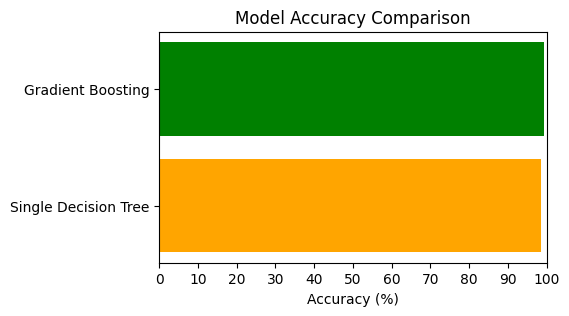

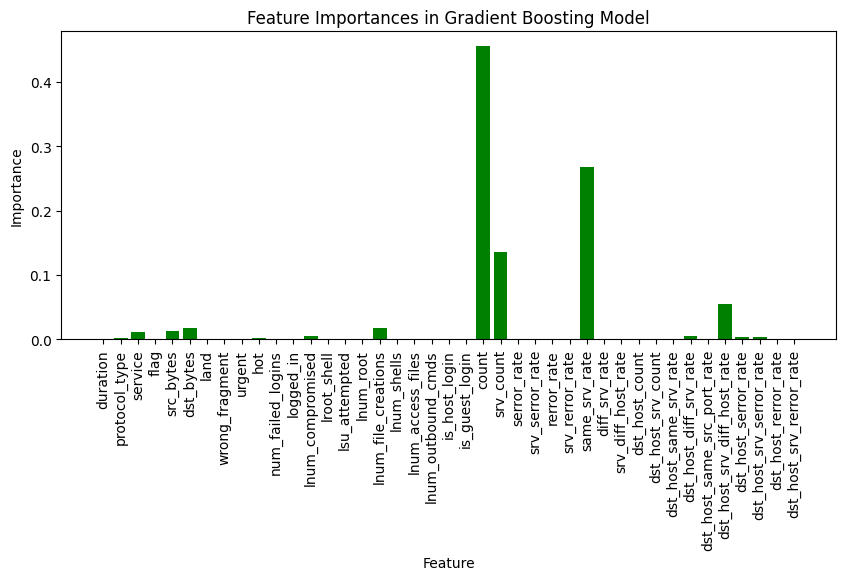


Conclusion and Interpretation:
From the comparison, we can observe that the Gradient Boosting model has a higher accuracy than the single decision tree model.
This demonstrates the effectiveness of the Gradient Boosting technique in improving the performance of weak learners by focusing on the errors of the previous trees.
The visualization of feature importances provides insights into which features the model deems most important. This can inform feature engineering efforts and provide understanding of the underlying decision-making process of the model.
The results underscore the utility of ensemble methods in creating robust and accurate predictive models.



In [7]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# For demonstration purposes, let's assume we're using the same dataset 'KDDCup99' as before.
# We would load the dataset, preprocess it, and prepare the feature matrix X and labels y just like we did for AdaBoost.

# Load the dataset from OpenML (same as with AdaBoost example)
data = fetch_openml(name='KDDCup99', version=1, as_frame=True, parser='auto')
df = data.frame

# Preprocess the dataset: encode categorical variables, handle missing values
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)
label_encoders = {}
for column in df.select_dtypes(include=['category', 'object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Prepare the data for training/testing
X = df.drop('label', axis=1)  # Features
y = df['label'].astype(int)   # Target variable

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a single Decision Tree Classifier for baseline comparison
single_tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
single_tree_clf.fit(X_train, y_train)
y_tree_pred = single_tree_clf.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_tree_pred) * 100

# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=52, # You can change this parameter, but it will cost a lot of time to finish
    learning_rate=0.1,
    max_depth=2, # You can change this parameter, but it will cost a lot of time to finish
    random_state=42
)

# Time the training of the Gradient Boosting Classifier
start_time = time.time()
# Train the Gradient Boosting Classifier
gb_clf.fit(X_train, y_train)
gb_train_time = time.time() - start_time
print(f"Gradient Boosting Training Time: {gb_train_time:.3f} seconds")

# Time the predictions with Gradient Boosting
start_time = time.time()
# Make predictions with Gradient Boosting
y_gb_pred = gb_clf.predict(X_test)
gb_predict_time = time.time() - start_time
print(f"Gradient Boosting Prediction Time: {gb_predict_time:.3f} seconds")

# Evaluate the Gradient Boosting Classifier
gb_accuracy = accuracy_score(y_test, y_gb_pred) * 100

# Print out accuracy scores for both models
print(f"Single Decision Tree Accuracy: {tree_accuracy:.2f}%")
print(f"Gradient Boosting Model Accuracy: {gb_accuracy:.2f}%")

# Generate classification reports
tree_report = classification_report(y_test, y_tree_pred, zero_division=1)
gb_report = classification_report(y_test, y_gb_pred, zero_division=1)
print("Single Decision Tree Classification Report:")
print(tree_report)
print("Gradient Boosting Model Classification Report:")
print(gb_report)

# Visualize the comparison between the base decision tree and gradient boosting classifier accuracies
plt.figure(figsize=(5, 3))
plt.barh(['Single Decision Tree', 'Gradient Boosting'], [tree_accuracy, gb_accuracy], color=['orange', 'green'])
plt.xlabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 100)  # Set the x-axis limits from 0 to 100 for percentages
plt.xticks(np.arange(0, 101, 10))  # Set the ticks to be in increments of 10%
plt.show()

# Visualize the feature importances of the gradient boosting model
gb_feature_importances = gb_clf.feature_importances_
plt.figure(figsize=(10, 4))
plt.bar(X.columns, gb_feature_importances, color='green')
plt.title("Feature Importances in Gradient Boosting Model")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.show()

# Conclusion and Interpretation
print("\nConclusion and Interpretation:")
print("From the comparison, we can observe that the Gradient Boosting model has a higher accuracy than the single decision tree model.")
print("This demonstrates the effectiveness of the Gradient Boosting technique in improving the performance of weak learners by focusing on the errors of the previous trees.")
print("The visualization of feature importances provides insights into which features the model deems most important. This can inform feature engineering efforts and provide understanding of the underlying decision-making process of the model.")
print("The results underscore the utility of ensemble methods in creating robust and accurate predictive models.\n")

# eXtreme Gradient Boosting (XGBoost)

Extreme Gradient Boosting, often abbreviated as XGBoost, is a powerful and highly efficient gradient boosting algorithm for both regression and classification tasks. XGBoost is an optimized and regularized version of the Gradient Boosting algorithm. It uses gradient boosting to build an ensemble of decision trees. However, XGBoost includes several innovative enhancements and regularization techniques to improve predictive accuracy, speed, and handling of large datasets.

Here are the steps followed by the XGBoost algorithm:
- **Step 1: Initialize the Model -** Begin with a base prediction which could be the average of the targets for regression, or probability of the classes for classification.
- **Step 2: Loop Over Boosting Rounds -** Add new models to the ensemble sequentially. Each new model is trained with respect to the error of the whole ensemble learned so far.
- **Step 3: Fit the Tree to Residuals -** Fit a decision tree to the residuals of the predictions. In XGBoost, the residuals are computed based on a chosen loss function and the predictions so far.
- **Step 4: Calculate the Loss -** Calculate the loss using a loss function suitable for the task at hand (e.g., logistic loss for classification tasks).
- **Step 5: Optimize Model -** XGBoost introduces the concept of regularization (L1 & L2), which can be optimized alongside the loss function to prevent overfitting.
- **Step 6: Update the Model  -** Update the model by adding the new tree with a scaling factor called the learning rate.
- **Step 7: Prune the Tree -** XGBoost allows for the pruning of trees, unlike traditional gradient boosting methods that grow trees to their full depth first and then prune.
- **Step 8: Combine Trees -** The final prediction model is an ensemble of all trees built during the boosting rounds.
- **Step 9: Cross-validation -** XGBoost allows for built-in cross-validation at each iteration of the boosting process, which allows for robust assessment of model performance.
- **Step 10: Terminate or Continue -** The boosting process can continue until a specified number of boosting rounds are completed or until no further improvements can be made.

### Practical Example of Using XGBoost:

In this practical session, we are going to applying the XGBoost algorithm to a real-world dataset. The example demostrates:
1. Comprehension of XGBoost and its operational steps.
2. Application of XGBoost to a dataset and evaluation of its performance.
3. Comparison of XGBoost's performance to a single decision tree.
4. Visualization of the model's feature importances.

The XGBoost library in Python is designed to provide an efficient implementation of gradient tree boosting, with additional features like regularization, which helps in preventing overfitting and can improve overall model performance.

Base Model Accuracy (Single Decision Tree): 99.31%
XGBoost Model Accuracy: 99.98%
XGBoost Model Training Time: 18.276 seconds
XGBoost Model Prediction Time: 0.165 seconds
Base Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      0.33      0.50        12
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00       382
           6       1.00      0.43      0.60         7
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00     31983
          10       0.96      0.43      0.59        61
          11       0.97      1.00      0.98     29154
          12       0.00      0.00      0.00         2
          14       0.00      0.00     

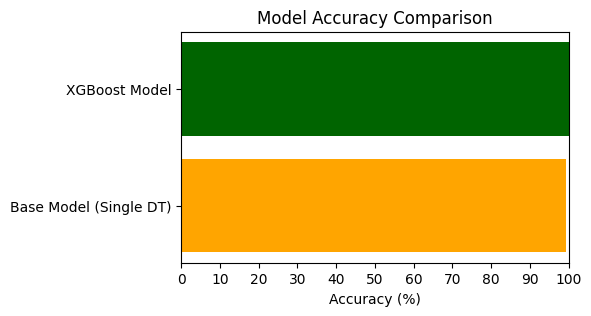

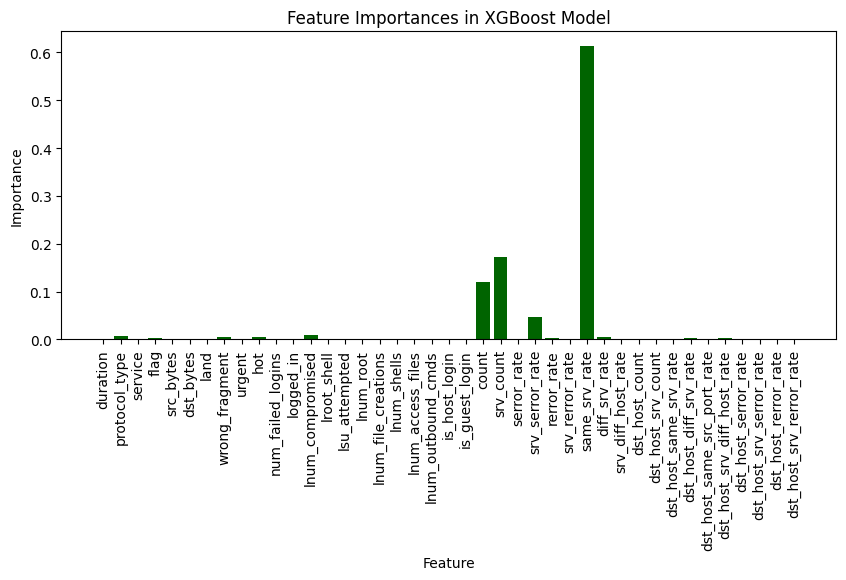


Conclusion and Interpretation:
From the comparison, we observe that the XGBoost model outperforms the single decision tree model.
The feature importances plot reveals which features the model considers most predictive for the given task.
XGBoost's model accuracy and feature importance analysis provide valuable insights for model tuning and interpretation.



In [10]:
# Importing necessary libraries
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import time  # Import the time library
import numpy as np

# Load the dataset from OpenML
data = fetch_openml(name='KDDCup99', version=1, as_frame=True, parser='auto')
df = data.frame

# Preprocess the dataset
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)
label_encoders = {}
for column in df.select_dtypes(include=['category', 'object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Prepare the data for training/testing
X = df.drop('label', axis=1)  # Features
y = df['label'].astype(int)   # Target variable

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the single Decision Tree model as a base model for comparison
base_clf = xgb.XGBClassifier(max_depth=3, n_estimators=1)  # Setting n_estimators=1 to mimic a single decision tree
base_clf.fit(X_train, y_train)
y_base_pred = base_clf.predict(X_test)
base_accuracy = accuracy_score(y_test, y_base_pred) * 100
print(f"Base Model Accuracy (Single Decision Tree): {base_accuracy:.2f}%")

# Create an XGBoost model and measure the time
start_time = time.time()
xg_clf = xgb.XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.1, random_state=42)
xg_clf.fit(X_train, y_train)
xg_train_time = time.time() - start_time

start_time = time.time()
y_xg_pred = xg_clf.predict(X_test)
xg_predict_time = time.time() - start_time

xg_accuracy = accuracy_score(y_test, y_xg_pred) * 100
print(f"XGBoost Model Accuracy: {xg_accuracy:.2f}%")
print(f"XGBoost Model Training Time: {xg_train_time:.3f} seconds")
print(f"XGBoost Model Prediction Time: {xg_predict_time:.3f} seconds")

# Generate and compare classification reports
base_report = classification_report(y_test, y_base_pred, zero_division=0)
xg_report = classification_report(y_test, y_xg_pred, zero_division=0)
print("Base Model Classification Report:")
print(base_report)
print("XGBoost Model Classification Report:")
print(xg_report)

# Visualize the comparison of model accuracies
plt.figure(figsize=(5, 3))
plt.barh(['Base Model (Single DT)', 'XGBoost Model'], [base_accuracy, xg_accuracy], color=['orange', 'darkgreen'])
plt.xlabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 100)  # Set the x-axis limits from 0 to 100 for percentages
plt.xticks(np.arange(0, 101, 10))  # Set the ticks to be in increments of 10%
plt.show()

# Visualize the feature importances of the XGBoost model
xg_feature_importances = xg_clf.feature_importances_
plt.figure(figsize=(10, 4))
plt.bar(X.columns, xg_feature_importances, color='darkgreen')
plt.title("Feature Importances in XGBoost Model")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

# Conclusion and Interpretation
print("\nConclusion and Interpretation:")
print("From the comparison, we observe that the XGBoost model outperforms the single decision tree model.")
print("The feature importances plot reveals which features the model considers most predictive for the given task.")
print("XGBoost's model accuracy and feature importance analysis provide valuable insights for model tuning and interpretation.\n")

# Comparative Analysis

In [ ]:
import pandas as pd

# Hypothetical data
results = {
    'Model': ['AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [ada_accuracy, gb_accuracy, xg_accuracy],  
    'Training Time': [ada_train_time, gb_train_time, xg_train_time],  
    'Prediction Time': [ada_predict_time, gb_predict_time, xg_predict_time],  
}

results_df = pd.DataFrame(results)
print(results_df)

# Visualizing the accuracy of each model
plt.figure(figsize=(5, 3))
plt.bar(results_df['Model'], results_df['Accuracy'], color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.xlabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.yticks(np.arange(0, 101, 10))  # Set the ticks to be in increments of 10%
plt.ylim(0, 100)  # Assuming accuracy is between 0 and 1
plt.show()

# Visualizing the training time of each model
plt.figure(figsize=(5, 3))
plt.bar(results_df['Model'], results_df['Training Time'], color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Comparison of Model Training Times')
plt.show()

# Visualizing the prediction time of each model
plt.figure(figsize=(5, 3))
plt.bar(results_df['Model'], results_df['Prediction Time'], color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Prediction Time (seconds)')
plt.title('Comparison of Model Prediction Times')
plt.show()

## Final notes:
When comparing AdaBoost, Gradient Boosting, and XGBoost, there are several factors to consider beyond just accuracy, such as training time and prediction time.

**AdaBoost** is often faster to train than the other two boosting methods, making it a good choice for quick prototyping or when working with smaller datasets. However, it may not perform as well with very noisy data or complex problems where the decision boundaries are not as straightforward.

**Gradient Boosting** is a more robust technique compared to AdaBoost and tends to perform better on a wider range of problems, including those with complex decision boundaries and heterogeneous features. It is slower than AdaBoost due to the sequential nature of boosting the weak learners, but it often results in better performance.

**XGBoost** is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. XGBoost provides a parallel tree boosting that solves many data science problems in a fast and accurate way. For large datasets, or when you are seeking the highest accuracy, XGBoost is often the preferred algorithm due to its efficiency and the capability of handling sparse data.

In summary, **AdaBoost** can be preferred for its simplicity and speed, **Gradient Boosting** for its robustness, and **XGBoost** for its performance and scalability. The choice of algorithm ultimately depends on the specific problem, the size and nature of the data, the computational resources available, and the balance between training time and model performance that you are willing to make.